## 1.1 线性回归
数学表达式为：$$ \hat{y} = X{\omega} + b$$
损失函数：$$\sum_{i=1}^{n}(\hat{y_{i}} - {y_{i}})^2$$
## 1.2 创建数据集
设随机数据集$X[i]$是一个二维数据，$y[i]$是对应的输出值
$$y[i] = 2* X[i][0] - 3.4*X[i][1] + 4.2 + noise$$
数学符号表示：
$$y = X\omega +b +\eta,\quad for \, \eta \sim N(0,\sigma^2)$$
噪声服从零均值，标准差为0.01的正态分布

In [39]:
import mxnet.ndarray as nd
import mxnet.autograd as ag
import numpy as np

num_inputs = 2
num_examples = 1000

true_w = [2, -3.4]
true_b = 4.2

X = nd.random_normal(shape=(num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] *  X[:, 1] + true_b
y += 0.01 * nd.random_normal(shape=y.shape)
print(X[0],y[0])


[-0.79256582  1.72738349]
<NDArray 2 @cpu(0)> 
[-3.25422263]
<NDArray 1 @cpu(0)>


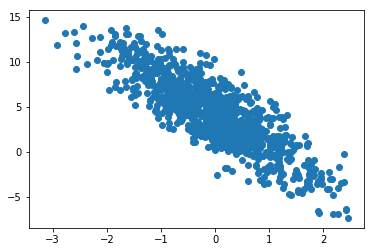

In [40]:
import matplotlib.pyplot as plt
plt.scatter(X[:,1].asnumpy(), y.asnumpy())
plt.show()

## 1.3 数据读取
在训练神经网络的过程中需要不断的读取数据块，定义一个数据读取函数，使其每次返回一个batch_size个样本和对应的目标，通过Python的yield来构造一个迭代器。

In [41]:
import random
batch_size = 10
def data_iter():
    #generate a random index
    idx = list(range(num_examples))
    random.shuffle(idx)
    for i in range(0, num_examples, batch_size):
        j = nd.array(idx[i: min(i + batch_size, num_examples)])
        yield nd.take(X, j), nd.take(y, j)
for data, label in data_iter():
    print(data, label)
    break
        


[[-1.09439468  1.01678252]
 [ 0.57954556  1.2427572 ]
 [ 0.18014392  0.13980889]
 [-1.24947369  0.97720391]
 [-0.12071847  1.21272457]
 [ 0.44612426 -1.10204816]
 [-0.44283888 -0.58197826]
 [ 0.49228969 -0.72555274]
 [-2.06176519 -0.13348094]
 [-0.130546   -0.15949044]]
<NDArray 10x2 @cpu(0)> 
[-1.45487022  1.11981297  4.07223082 -1.62257421 -0.17500317  8.85054493
  5.2941103   7.66203928  0.52777493  4.49872017]
<NDArray 10 @cpu(0)>


## 1.4 初始化模型参数
初始化模型参数w和b，在模型训练过程中通过求导来对参数进行更新，使得损失函数值最小。

In [42]:
w = nd.random_normal(shape=(num_inputs, 1))
b = nd.zeros((1,))
params = [w, b]
for param in params:
    param.attach_grad()

## 1.5 定义模型
确定模型结构

In [43]:
def net(X):
    return nd.dot(X, w) + b

## 1.6 定义损失函数
常用损失函数：平方误差，绝对值距离，交叉熵损失。

In [44]:
def square_loss(yhat, y):
    return (yhat - y.reshape(yhat.shape))**2

## 1.7 优化
选择优化方法：随机梯度下降，mini-batch随机梯度，Adam，momentum，RMSProp

In [45]:
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

## 1.8 训练
通常需要设定迭代次数epochs，每次迭代中随机抽取固定个数的数据点，计算梯度并更新模型

Epoch 0, batch 99. Moving avg of loss: 5.06487720138. Average loss: 6.736245


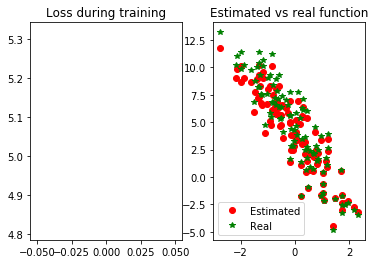

Epoch 1, batch 199. Moving avg of loss: 1.40986489704. Average loss: 0.102920


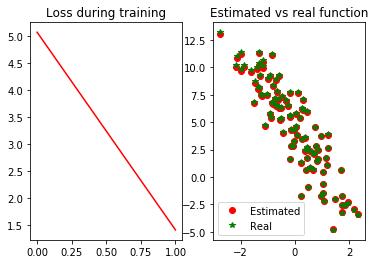

Epoch 2, batch 299. Moving avg of loss: 0.470362285201. Average loss: 0.001730


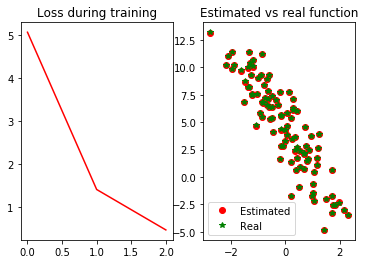

Epoch 3, batch 399. Moving avg of loss: 0.166743974722. Average loss: 0.000131


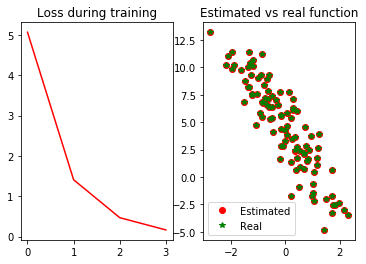

Epoch 4, batch 499. Moving avg of loss: 0.0603940675447. Average loss: 0.000105


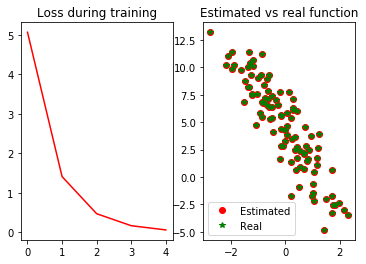

In [46]:
#定义模型函数
def real_fn(X):
    return 2 * X[:, 0] - 3.4 * X[:,1] + 4.2
# 绘制损失随训练次数降低的折线图，以及预测值和真实值的散点图
def plot(losses, X, sample_size= 100):
    xs = list(range(len(losses)))
    f, (fg1, fg2) = plt.subplots(1, 2)
    fg1.set_title('Loss during training')
    fg1.plot(xs, losses, '-r')
    fg2.set_title('Estimated vs real function')
    fg2.plot(X[:sample_size, 1].asnumpy(), net(X[:sample_size,:]).asnumpy(), 'or',label='Estimated')
    fg2.plot(X[:sample_size, 1].asnumpy(), real_fn(X[:sample_size, :]).asnumpy(), '*g',label='Real')
    fg2.legend()
    plt.show()
    
epochs = 5
learning_rate = .001
niter = 0
losses = []
moving_loss = 0
smoothing_constant = .01

# 训练
for e in range(epochs):
    total_loss = 0
    for data, label in data_iter():
        with ag.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        SGD(params, learning_rate)
        total_loss += nd.sum(loss).asscalar()
        
        #记录读取每个数据的后，损失的移动平均值变化
        niter += 1
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss
        
        # 利用移动平均值来修正偏差
        est_loss = moving_loss /(1- (1 - smoothing_constant)** niter)
        if (niter + 1) % 100 == 0:
            losses.append(est_loss)
            print("Epoch %s, batch %s. Moving avg of loss: %s. Average loss: %f" % (e, niter, est_loss, total_loss/num_examples))
            plot(losses, X)


## 2.1 线性回归（Gluon）



[[-0.05782295 -0.97028762]
 [ 0.16011156 -0.28234869]
 [-0.16097534  1.06405056]
 [ 1.41383934  1.88842118]
 [ 1.16354227 -1.30204594]
 [-1.17696309 -0.83743268]
 [ 1.11314785  0.29752973]
 [ 0.40954578 -0.1609962 ]
 [-0.36570126  1.532516  ]
 [ 0.16805364  0.76307821]]
<NDArray 10x2 @cpu(0)> 
[  7.38510084   5.48678207   0.26446322   0.59344018  10.95193005
   4.70492125   5.43585443   5.55130291  -1.74595451   1.94742203]
<NDArray 10 @cpu(0)>
Epoch 0, batch 1099. Moving avg of loss: 0.392356031674. Average loss: 0.903932


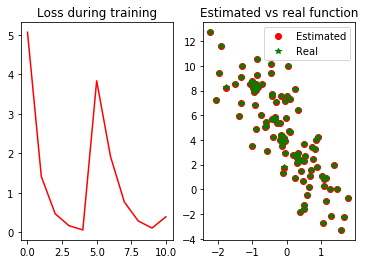

Epoch 0, average loss: 0.903932
Epoch 1, batch 1199. Moving avg of loss: 0.143645555331. Average loss: 0.000050


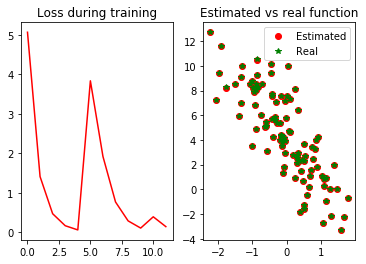

Epoch 1, average loss: 0.000050
Epoch 2, batch 1299. Moving avg of loss: 0.0526108073448. Average loss: 0.000051


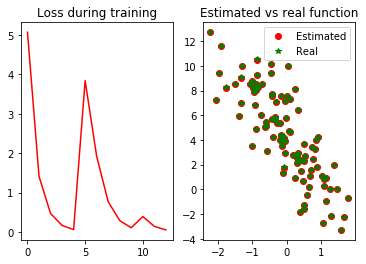

Epoch 2, average loss: 0.000051
Epoch 3, batch 1399. Moving avg of loss: 0.0192900360636. Average loss: 0.000051


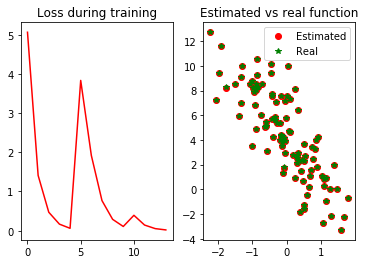

Epoch 3, average loss: 0.000051
Epoch 4, batch 1499. Moving avg of loss: 0.00709311093411. Average loss: 0.000051


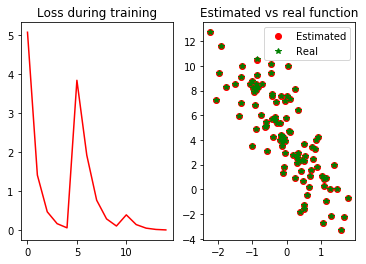

Epoch 4, average loss: 0.000051


In [49]:
# 创建数据集
from mxnet import gluon
num_inputs = 2
num_examples = 1000

true_w = [2, -3.4]
true_b = 4.2

X = nd.random_normal(shape=(num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += .01 * nd.random_normal(shape=y.shape)

def real_fn(X):
    return 2 * X[:, 0] - 3.4 * X[:,1] + 4.2
# 绘制损失随训练次数降低的折线图，以及预测值和真实值的散点图
def plot_gluon(losses, X, sample_size= 100):
    xs = list(range(len(losses)))
    f, (fg1, fg2) = plt.subplots(1, 2)
    fg1.set_title('Loss during training')
    fg1.plot(xs, losses, '-r')
    fg2.set_title('Estimated vs real function')
    fg2.plot(X[:sample_size, 1].asnumpy(), net(X[:sample_size,:]).asnumpy(), 'or',label='Estimated')
    fg2.plot(X[:sample_size, 1].asnumpy(), real_fn(X[:sample_size, :]).asnumpy(), '*g',label='Real')
    fg2.legend()
    plt.show()

# 读取数据
batch_size = 10
dataset = gluon.data.ArrayDataset(X, y)
data_iter = gluon.data.DataLoader(dataset, batch_size, shuffle=True)

for data, label in data_iter:
    print(data, label)
    break

# 定义模型
net = gluon.nn.Sequential()
net.add(gluon.nn.Dense(1))

# 初始化模型参数
net.initialize()

# 定义模型损失函数
square_loss = gluon.loss.L2Loss()

# 优化
trainer = gluon.Trainer(params=net.collect_params(),optimizer='sgd',optimizer_params={'learning_rate':.1})

# 训练
epochs = 5
batch_size = 10
for e in range(epochs):
    total_loss = 0
    for data, label in data_iter:
        with ag.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        trainer.step(batch_size)
        total_loss += nd.sum(loss).asscalar()
        
         #记录读取每个数据的后，损失的移动平均值变化
        niter += 1
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss
        
        # 利用移动平均值来修正偏差
        est_loss = moving_loss /(1- (1 - smoothing_constant)** niter)
        if (niter + 1) % 100 == 0:
            losses.append(est_loss)
            print("Epoch %s, batch %s. Moving avg of loss: %s. Average loss: %f" % (e, niter, est_loss, total_loss/num_examples))
            plot_gluon(losses, X)
    print("Epoch %d, average loss: %f" % (e, total_loss/num_examples))

In [34]:
help(trainer.step)

Help on method step in module mxnet.gluon.trainer:

step(batch_size, ignore_stale_grad=False) method of mxnet.gluon.trainer.Trainer instance
    Makes one step of parameter update. Should be called after
    `autograd.compute_gradient` and outside of `record()` scope.
    
    Parameters
    ----------
    batch_size : int
        Batch size of data processed. Gradient will be normalized by `1/batch_size`.
        Set this to 1 if you normalized loss manually with `loss = mean(loss)`.
    ignore_stale_grad : bool, optional, default=False
        If true, ignores Parameters with stale gradient (gradient that has not
        been updated by `backward` after last step) and skip update.



In [35]:
dense = net[0]
help(dense.weight)

Help on Parameter in module mxnet.gluon.parameter object:

class Parameter(builtins.object)
 |  A Container holding parameters (weights) of Blocks.
 |  
 |  :py:class:`Parameter` holds a copy of the parameter on each :py:class:`Context` after
 |  it is initialized with ``Parameter.initialize(...)``. If :py:attr:`grad_req` is
 |  not ``'null'``, it will also hold a gradient array on each :py:class:`Context`::
 |  
 |      ctx = mx.gpu(0)
 |      x = mx.nd.zeros((16, 100), ctx=ctx)
 |      w = mx.gluon.Parameter('fc_weight', shape=(64, 100), init=mx.init.Xavier())
 |      b = mx.gluon.Parameter('fc_bias', shape=(64,), init=mx.init.Zero())
 |      w.initialize(ctx=ctx)
 |      b.initialize(ctx=ctx)
 |      out = mx.nd.FullyConnected(x, w.data(ctx), b.data(ctx), num_hidden=64)
 |  
 |  Parameters
 |  ----------
 |  name : str
 |      Name of this parameter.
 |  grad_req : {'write', 'add', 'null'}, default 'write'
 |      Specifies how to update gradient to grad arrays.
 |  
 |      - ``'wr

In [47]:
help(trainer)


Help on Trainer in module mxnet.gluon.trainer object:

class Trainer(builtins.object)
 |  Applies an `Optimizer` on a set of Parameters. Trainer should
 |  be used together with `autograd`.
 |  
 |  Parameters
 |  ----------
 |  params : ParameterDict
 |      The set of parameters to optimize.
 |  optimizer : str or Optimizer
 |      The optimizer to use. See
 |      `help <http://mxnet.io/api/python/optimization.html#the-mxnet-optimizer-package>`_
 |      on Optimizer for a list of available optimizers.
 |  optimizer_params : dict
 |      Key-word arguments to be passed to optimizer constructor. For example,
 |      `{'learning_rate': 0.1}`. All optimizers accept learning_rate, wd (weight decay),
 |      clip_gradient, and lr_scheduler. See each optimizer's
 |      constructor for a list of additional supported arguments.
 |  kvstore : str or KVStore
 |      kvstore type for multi-gpu and distributed training. See help on
 |      :any:`mxnet.kvstore.create` for more information.
 |  c